# Modelos Machine Learning

### Aun no están terminados los modelos 

Una vez hecha la limpieza de datos vamos a pasar a crear los modelos para predecir los precios de airbnb según las caracteristicas de los alojamientos.

In [180]:
#Carga de Librerías

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#Transformacion de los datos 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#otras
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error

#Modelos básicos
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

#Arboles y ensamblaje 
from sklearn.ensemble import RandomForestRegressor


pd.set_option('display.max_rows', 500) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

In [110]:
#Carga de datos limpios
dfl = pd.read_csv('df_limpio.csv', delimiter=',').iloc[:, 1:]

In [111]:
dfl.head(3)

,host response time,host response rate,host verifications,latitude,longitude,property type,room type,bathrooms,bedrooms,beds,bed type,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,final neighbourhood,years being host
0,within an hour,84.0,3,40.406953,-3.670894,Apartment,Private room,2.0,1.0,1.0,Real Bed,7,183.0,30.0,1,5,1,1125,240,171,flexible,3,28.0,20.142857,Retiro,2
1,within a few hours,100.0,3,40.425904,-3.681647,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,13,100.0,30.0,1,0,2,1125,15,52,moderate,3,58.0,22.285714,Salamanca,2
2,within an hour,100.0,5,40.428352,-3.687155,Apartment,Entire home/apt,1.0,0.0,2.0,Real Bed,17,150.0,30.0,2,15,2,1125,292,36,flexible,4,70.0,20.571429,Salamanca,1


## Transformación de datos

### Variables categóricas

#### Categóricas ordinales, es decir, siguien un orden específico

En esta categoría encontramos *'host response time'* y *'cancellation policy'*

In [112]:
# Orden de las categorías
host_response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
cancellation_policy_order = ['flexible', 'moderate', 'strict']
encoder = OrdinalEncoder(categories=[host_response_time_order, cancellation_policy_order])
dfl_catord = dfl.copy()
dfl_catord['host response time'] = dfl['host response time'].map({category: i for i, category in enumerate(host_response_time_order)})
dfl_catord['cancellation policy'] = dfl['cancellation policy'].map({category: i for i, category in enumerate(cancellation_policy_order)})
dfl_catord.head(2)

,host response time,host response rate,host verifications,latitude,longitude,property type,room type,bathrooms,bedrooms,beds,bed type,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,final neighbourhood,years being host
0,0,84.0,3,40.406953,-3.670894,Apartment,Private room,2.0,1.0,1.0,Real Bed,7,183.0,30.0,1,5,1,1125,240,171,0,3,28.0,20.142857,Retiro,2
1,1,100.0,3,40.425904,-3.681647,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,13,100.0,30.0,1,0,2,1125,15,52,1,3,58.0,22.285714,Salamanca,2


#### Categóricas que no siguien un orden específico

In [113]:
categoricas =['property type','room type', 'bed type', 'final neighbourhood'   
]
encoder = OneHotEncoder()
dfl_cat = encoder.fit_transform(dfl_catord[categoricas])
dfl_cat = pd.DataFrame(dfl_cat.toarray(), columns=encoder.get_feature_names_out(categoricas))
data_encoded = pd.concat([dfl_catord.drop(categoricas, axis=1), dfl_cat], axis=1)

In [114]:
data_encoded.head(2)

,host response time,host response rate,host verifications,latitude,longitude,bathrooms,bedrooms,beds,amenities,security deposit,cleaning fee,guests included,extra people,minimum nights,maximum nights,availability 365,number of reviews,cancellation policy,features,price,average review,years being host,property type_Apartment,property type_Bed & Breakfast,property type_Condominium,property type_House,property type_Loft,property type_Other,room type_Entire home/apt,room type_Private room,room type_Shared room,bed type_Pull-out Sofa,bed type_Real Bed,final neighbourhood_Arganzuela,final neighbourhood_Carabanchel,final neighbourhood_Centro,final neighbourhood_Chamartín,final neighbourhood_Chamberí,final neighbourhood_Ciudad Lineal,final neighbourhood_Latina,final neighbourhood_Moncloa - Aravaca,final neighbourhood_Puente de Vallecas,final neighbourhood_Retiro,final neighbourhood_Salamanca,final neighbourhood_Tetuán
0,0,84.0,3,40.406953,-3.670894,2.0,1.0,1.0,7,183.0,30.0,1,5,1,1125,240,171,0,3,28.0,20.142857,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,100.0,3,40.425904,-3.681647,1.0,0.0,1.0,13,100.0,30.0,1,0,2,1125,15,52,1,3,58.0,22.285714,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Separación rain y test 

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded, data_encoded['price'], test_size=0.33, random_state=42)

## Modelos básicos

Para estos modelos necesitamos que las variables estén escaladas. 

#### Escalado de variables

In [116]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#### Modelos

#### 1. Regresión linear

#### WARNING: He intentado hacer varias formas de hacer los modelos, pero me parece raro que me de 1 el score

In [177]:
lr = LinearRegression(normalize=False)
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled,y_train)
X_test_scaled = scaler.transform(X_test)
predictions = lr.predict(X_test_scaled)
lr.score(X_test_scaled,y_test)
results_df = ( data_test
    .loc[:,['price']]
    .assign(PricePredicted=predictions)
    .assign(SquaredError=lambda x:(x.SalePrice - x.PricePredicted)**2)
)

C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


NameError: name 'data_test' is not defined

In [120]:
lr = LinearRegression()

#Fit model
lr.fit(X_train_scaled, y_train)

#actual
actual = y_test

train_score_lr = lr.score(X_train_scaled, y_train)
test_score_lr = lr.score(X_test_scaled, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))

The train score for lr model is 1.0
The test score for lr model is 1.0


In [131]:
# Create Linear Regression model
lr = LinearRegression()

# Calculate cross-validated R^2 scores and MAE
cv_r2_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mae_scores = -cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_median_absolute_error')

# Compute mean scores
lr_testing_set_score = np.mean(cv_r2_scores)
lr_median_abs_error = np.mean(cv_mae_scores)

print("The R^2 score on our testing data is: {:.3f}".format(lr_testing_set_score))
print("The median absolute error on our testing data is: {:.3f}".format(lr_median_abs_error))

The R^2 score on our testing data is: 1.000
The median absolute error on our testing data is: 0.000


In [ ]:
cv = KFold(n_splits = 5)
linreg = LinReg()

# Store r2 and median absolute error
MAE =[]
R2 = []

for train, test in cv.split(X_encoded):
    # Fit linreg
    linreg.fit(X_encoded.iloc[train], y.iloc[train])
    
    # Predict and score
    Y_predict = linreg.predict(X_encoded.iloc[test])
    R2.append(linreg.score(X_encoded.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], Y_predict))

# Output and store scores after CV
lin_testing_set_score = np.mean(R2)
lin_median_abs_error = np.mean(MAE)
print 'The R^2 score on our testing data is: ' + str(round(lin_testing_set_score, 3))
print 'The median absolute error on our testing data is: ' + str(round(lin_median_abs_error, 3))

#### 2. Ridge Regression

In [160]:
ridge = Ridge(alpha=10, fit_intercept=False)

# Calculate cross-validated R^2 scores and MAE
cv_r2_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mae_scores = -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_median_absolute_error')

# Compute mean scores
ridge_testing_set_score = np.mean(cv_r2_scores)
ridge_median_abs_error = np.mean(cv_mae_scores)

print("The R^2 score on our testing data is: {:.3f}".format(ridge_testing_set_score))
print("The median absolute error on our testing data is: {:.3f}".format(ridge_median_abs_error))

The R^2 score on our testing data is: -0.461
The median absolute error on our testing data is: 68.482


In [176]:
# Tuning paramater values for Ridge
lambdas = 10.**np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])

# Perform Ridge regression using expanded set of predictors, 
# choose best regularization parameter lambda using 5-fold x-validation
cv = KFold(n_splits = 5)
ridge = RidgeCV(alphas = lambdas, fit_intercept = False, normalize = True, cv = 5)

# Store r2 and median absolute error
MAE =[]
R2 = []

# Find best score by cross validating over 5 folds
for train, test in cv.split(data_encoded):
    # Fit linreg
    ridge.fit(data_encoded.iloc[train], y.iloc[train])
    
    # Predict and score
    Y_predict = ridge.predict(data_encoded.iloc[test])
    R2.append(ridge.score(data_encoded.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], Y_predict))
    
# Output and store scores after CV
ridge_testing_set_score = np.mean(R2)
ridge_median_abs_error = np.mean(MAE)
print ('The R^2 score on our testing data is: ' + str(round(ridge_testing_set_score,3)))
print ('The median absolute error on our testing data is: ' + str(round(ridge_median_abs_error,3)))

C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.72476e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.67285e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.74599e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.73738e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\mllanos\Documents\Downloads

The R^2 score on our testing data is: 1.0
The median absolute error on our testing data is: 0.0


C:\Users\mllanos\Documents\Downloads\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.53679e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [106]:
ridgeReg = Ridge(alpha=10)

ridgeReg.fit(X_train_scaled,y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train_scaled, y_train)
test_score_ridge = ridgeReg.score(X_test_scaled, y_test)

print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

The train score for ridge model is 0.9999971945637722
The test score for ridge model is 0.9999972431313143


#### 3. Lasso 

In [166]:
lasso = Lasso(alpha=0.01, fit_intercept=False)

# Calculate cross-validated R^2 scores and MAE
cv_r2_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mae_scores = -cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_median_absolute_error')

# Compute mean scores
lasso_testing_set_score = np.mean(cv_r2_scores)
lasso_median_abs_error = np.mean(cv_mae_scores)

print("The R^2 score on our testing data is: {:.3f}".format(lasso_testing_set_score))
print("The median absolute error on our testing data is: {:.3f}".format(lasso_median_abs_error))

The R^2 score on our testing data is: -0.465
The median absolute error on our testing data is: 68.475


In [173]:
lambdas = 10.**np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
y = data_encoded['price']
cv = KFold(n_splits = 5)
lasso = LassoCV(alphas = lambdas, tol = 0.01, fit_intercept = False, normalize = True, cv = 5)

# Store r2 and median absolute error
MAE =[]
R2 = []

# Find best score by cross validating over 5 folds
for train, test in cv.split(data_encoded):
    # Fit linreg
    lasso.fit(data_encoded.iloc[train], y.iloc[train])
    
    # Predict and score
    Y_predict = lasso.predict(data_encoded.iloc[test])
    R2.append(lasso.score(data_encoded.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], Y_predict))

# Output and store scores after CV
lasso_testing_set_score = np.mean(R2)
lasso_median_abs_error = np.mean(MAE)
print ('The R^2 score on our testing data is: ' + str(round(lasso_testing_set_score,3)))
print ('The median absolute error on our testing data is: ' + str(round(lasso_median_abs_error,3)))

The R^2 score on our testing data is: 0.993
The median absolute error on our testing data is: 2.06


In [123]:
#Lasso regression model
lasso = Lasso(alpha = 10)
lasso.fit(X_train_scaled,y_train)
train_score_ls =lasso.score(X_train_scaled,y_train)
test_score_ls =lasso.score(X_test_scaled,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.9719127033310468
The test score for ls model is 0.9719077158233111


## Árboles y ensamblaje

#### Random Forest Regressor 

Los árboles no necesitan que los modelos estén estandarizados a si que primero probaremos con los datos sin estandarizar

In [181]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.412584962779156


#### 5. Selección del algoritmo/modelo: Existen varios algoritmos y modelos que puedes utilizar para crear un evaluador automático de precios, como regresión lineal, regresión logística, árboles de decisión, redes neuronales, etc. La elección del modelo dependerá de la naturaleza de tus datos y del rendimiento que desees lograr. 

- Regresión logística
- K-NN
- Arbol de decisión simple
- Bagging Classifier
- Random Forest
- GradientBoost

#### 6.Entrenamiento del modelo: Utiliza el conjunto de entrenamiento para entrenar tu modelo utilizando el algoritmo seleccionado. Durante el entrenamiento, el modelo aprenderá a establecer una relación entre las características del alojamiento y sus respectivos precios. 
#### 7. Evaluación del modelo: Después de entrenar el modelo, evalúa su rendimiento utilizando el conjunto de prueba. Utiliza métricas adecuadas, como el error medio absoluto (MAE) o el error cuadrático medio (MSE), para evaluar qué tan bien se ajusta el modelo a los precios reales de los alojamientos. También comprobar: Accuracy, Precision, Recall, Confusion Matrix, F-SCORE, Curva ROC, Area bajo la curva.

(Primero se hace un modelo muy simple y despues se sjustan los parametros para mejorarlo)

#### 8. Ajuste del modelo: Si el rendimiento del modelo no es satisfactorio, puedes realizar ajustes en los hiperparámetros del algoritmo o probar diferentes modelos para mejorar su rendimiento. También puedes considerar técnicas de regularización o ingeniería de características adicionales.

#### 9. Implementación y despliegue: Una vez que estés satisfecho con el rendimiento de tu modelo, puedes implementarlo en un sistema en línea donde los usuarios puedan ingresar las características de un alojamiento y obtener una estimación automática del precio.

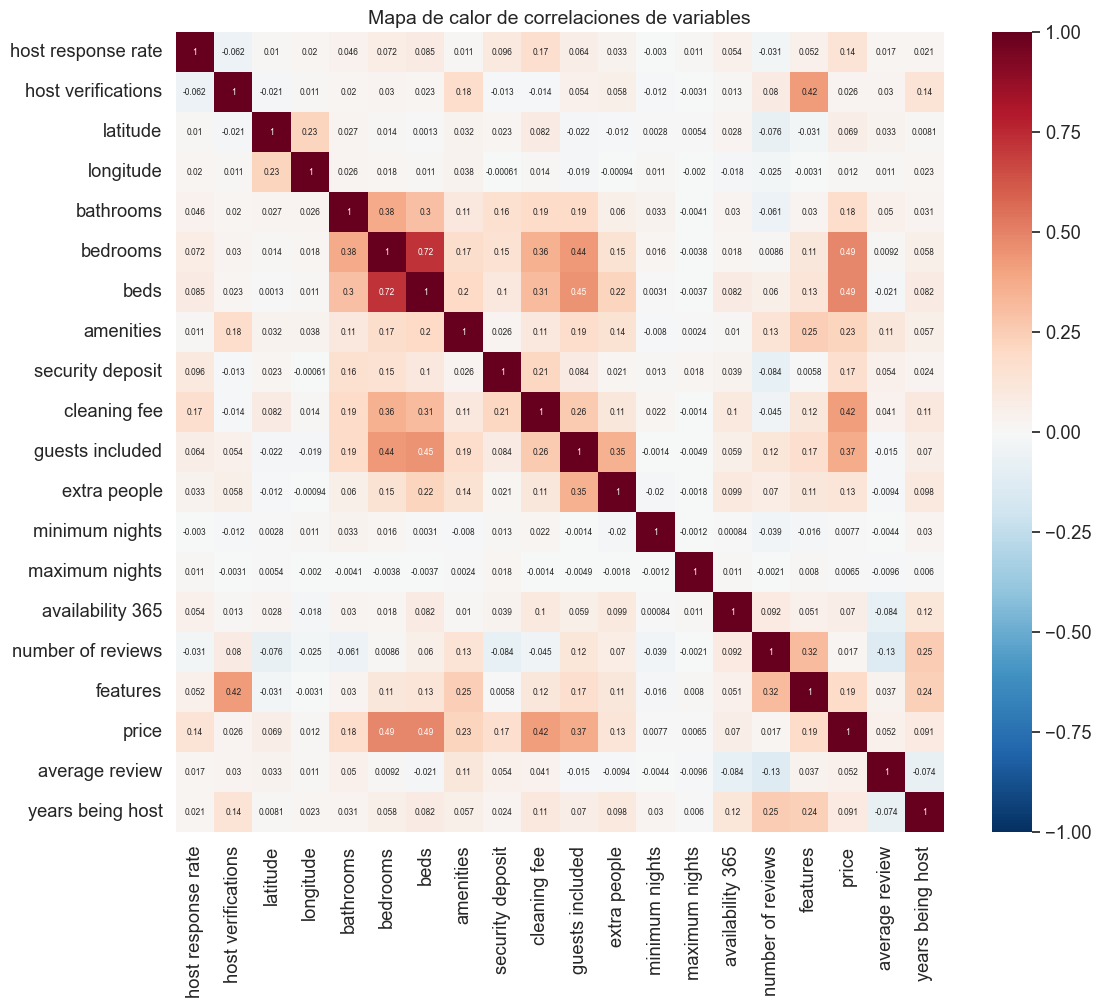

In [8]:
corr_dfl = dfl.corr(method='pearson')
plt.figure(figsize=(12,10))
sns.set(font_scale=1.2)
cmap = sns.diverging_palette(10, 220, sep=80, n=7)
sns.heatmap(corr_dfl, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, annot_kws={"fontsize":6})
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95)
plt.title('Mapa de calor de correlaciones de variables', fontsize=14)
plt.show()